In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
import plotly.express as px
import plotly
import seaborn as sns
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from bs4 import BeautifulSoup
import spacy
import unidecode 
import contractions
from nltk.stem import WordNetLemmatizer 
import re
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ivan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
a = np.array([1,2,3])
b = np.array([4,5,6])
c = np.column_stack((a,b))
d = np.array([6,6,6])
print(np.column_stack((c,d)))

[[1 4 6]
 [2 5 6]
 [3 6 6]]


In [108]:
'''
This will load the csv
'''

class CsvToDf:
    '''
    This class will simply turn the given data to a dataframe
    '''
    def __init__(self,filename,batchSize=None,cols=None,preProc=False,postCol=False,toReplace=None):
        #batchSize is the size of data to be read incrementally. This is for data that is to big to fit
        #into memory
        self._toReplace = toReplace
        self._preProc = preProc
        self._postCol = postCol
        self._cols = cols
        self._header = None
        self._filename = filename
        self._curIndex = 0     #this will be the current index that we are in the csv
        self._isRead = False
        self._df = None
        self._storeHeader()
        self._batchSize = batchSize
    def preprocessing_v1(self,text):
        #remove html information
        soup = BeautifulSoup(text, "html.parser")
        processed = soup.get_text(separator=" ")

        #remove http// 
        processed = re.sub(r"http\S+", "", processed)

        #remove ||| seperate
        processed = re.sub(r'\|\|\|', r' ', processed)

        #lower case
        processed = processed.lower()

        #expand shortened words, e.g. don't to do not
        processed = contractions.fix(processed)

        #remove accented char
        processed = unidecode.unidecode(processed)

        #remove white space
        #processed = processed.strip()
        #processed = " ".join(processed.split())

        # Lemmatizing 
        lemmatizer = WordNetLemmatizer() 
        processed=lemmatizer.lemmatize(processed)
        return processed
    def _storeHeader(self):
        with open(self._filename) as csvFile:
            f = csv.reader(csvFile)
            self._header = next(f)
    def getWholeCsv(self):
        if not(self._isRead):
            if self._cols != None:
                self._df = pd.read_csv(self._filename,usecols=self._cols)
            else:
                self._df = pd.read_csv(self._filename)
            self._isRead = True
        return self._df
    def getHeader(self):
        return self._header
    def _checkIfRead(self):
        if not(self._isRead):
            if self._cols != None:
                self._df = pd.read_csv(self._filename,iterator=True,chunksize=self._batchSize,usecols=self._cols)
            else:
                self._df = pd.read_csv(self._filename,iterator=True,chunksize=self._batchSize)
            self._isRead = True
            return False
        return True
    def removeWord(self,text):
        words = text.split()
        cleanWords = [i for i in words if i not in self._toReplace]
        return " ".join(cleanWords)
    def getNextBatchCsv(self):
        self._checkIfRead()
        out = next(self._df,None)
        if self._preProc and isinstance(out,pd.DataFrame):
            out[self._postCol] = out[self._postCol].apply(self.preprocessing_v1)
        if self._toReplace != None and isinstance(out,pd.DataFrame):
            out[self._postCol] = out[self._postCol].apply(self.removeWord)
        return out

In [43]:
#================ counting the smallest number of data
TEST = "test"
TRAIN = "train"
class Combiner:
    '''
    - Given multiple CsvToDf that correspond to a dataset combine them to a single dataframe
    - return this dataframe
    - need to return a dataframe that only has type and post as its columns
    '''
    def __init__(self,dataList,columnList):
        '''
        dataList is the CsvToDf that contains all the data and columnList is a list that contains the necessary
        column names for a corresponding entry in dataList.
        '''
        assert len(dataList) == len(columnList),"incorrect sizes for data"
        self._dataList = dataList
        self._data = [None for i in range(len(dataList))]
        self._necessaryCol = columnList
        self._typeCol = "type"
        self._postCol = "posts"
        self._incrementData()
    def getNextBatch(self):
        '''
        return a dataframe that contains all the aggregated data
        '''
        outData = pd.DataFrame(columns=[self._typeCol,self._postCol])
        for data,colList in zip(self._data,self._necessaryCol):
            if isinstance(data,pd.DataFrame):
                renamedData = data[[colList[0],colList[1]]]
                renamedData.columns = [self._typeCol,self._postCol]
                
                outData = outData.append(renamedData,ignore_index=True)
        self._incrementData()
        if (len(outData.index)) == 0:
            return None
        else:
            return outData
    def _incrementData(self):
        for idx,i in enumerate(self._dataList):
            self._data[idx] = i.getNextBatchCsv()
class Balancer:
    '''
    - Balance the count
    - Decide what the training and test dat will be
    - Needs to output three data frames the train the test and the remainder
    - make the remainder the training set
    '''
    def __init__(self,combiner,trainFreq,testFreq):
        #personSize is minimum size of the number of people in a single personality group
        self._combiner = combiner
        self._typeCol = "type"
        self._postCol = "posts"
        self._personality_count = {"ENTJ" : {TRAIN:0,TEST:0}, "INTJ" : {TRAIN:0,TEST:0}, "ENTP" : {TRAIN:0,TEST:0}, "INTP" : {TRAIN:0,TEST:0}, "INFJ" : {TRAIN:0,TEST:0}, "INFP" : {TRAIN:0,TEST:0}, "ENFJ" : {TRAIN:0,TEST:0} , 
                    "ENFP" : {TRAIN:0,TEST:0}, "ESTP" : {TRAIN:0,TEST:0}, "ESTJ" : {TRAIN:0,TEST:0}, "ISTP" : {TRAIN:0,TEST:0}, "ISTJ" : {TRAIN:0,TEST:0}, "ISFJ" : {TRAIN:0,TEST:0}, "ISFP" : {TRAIN:0,TEST:0}, 
                    "ESFJ" : {TRAIN:0,TEST:0}, "ESFP" : {TRAIN:0,TEST:0}}
        self._trainFreq = trainFreq
        self._testFreq = testFreq
        self._training = []
        self._testing = []
    def createDataSets(self):
        self.reset()
        while not(self._trainIsUniform()) or not(self._testIsUniform()):
            #the three conditionals above will check if test and train dataset have uniform data 
            batch = self._combiner.getNextBatch()
            if not(isinstance(batch,pd.DataFrame)):
                break
            for idx,row in batch.iterrows():
                if isinstance(row[self._typeCol],str):
                    personality = row[self._typeCol].upper()
                    if personality in self._personality_count:
                        if self._personality_count[personality][TRAIN] < self._trainFreq:
                            self._training.append({self._typeCol:personality,self._postCol:row[self._postCol]})
                            self._personality_count[personality][TRAIN] += 1
                        elif self._personality_count[personality][TEST] < self._testFreq:
                            self._testing.append({self._typeCol:personality,self._postCol:row[self._postCol]})
                            self._personality_count[personality][TEST] += 1
        return True
    def reset(self):
        self._training = []
        self._testing = []
        self._personality_count = {"ENTJ" : {TRAIN:0,TEST:0}, "INTJ" : {TRAIN:0,TEST:0}, "ENTP" : {TRAIN:0,TEST:0}, "INTP" : {TRAIN:0,TEST:0}, "INFJ" : {TRAIN:0,TEST:0}, "INFP" : {TRAIN:0,TEST:0}, "ENFJ" : {TRAIN:0,TEST:0} , 
                    "ENFP" : {TRAIN:0,TEST:0}, "ESTP" : {TRAIN:0,TEST:0}, "ESTJ" : {TRAIN:0,TEST:0}, "ISTP" : {TRAIN:0,TEST:0}, "ISTJ" : {TRAIN:0,TEST:0}, "ISFJ" : {TRAIN:0,TEST:0}, "ISFP" : {TRAIN:0,TEST:0}, 
                    "ESFJ" : {TRAIN:0,TEST:0}, "ESFP" : {TRAIN:0,TEST:0}}
    def getTrainSet(self):
        return pd.DataFrame(self._training)
    def getTestSet(self):
        return pd.DataFrame(self._testing)
    def _trainIsUniform(self):
        #checks if personality count has equal distribution
        for key in self._personality_count:
            if self._personality_count[key][TRAIN] < self._trainFreq:
                return False
        return True
    def _testIsUniform(self):
        #checks if personality count has equal distribution
        for key in self._personality_count:
            if self._personality_count[key][TEST] < self._testFreq:
                return False
        return True
#======================================================

In [11]:
def counter(ctd):
    personality_dict = {"ENTJ" : 0, "INTJ" : 0, "ENTP" : 0, "INTP" : 0, "INFJ" : 0, "INFP" : 0, "ENFJ" : 0, 
                    "ENFP" : 0, "ESTP" : 0, "ESTJ" : 0, "ISTP" : 0, "ISTJ" : 0, "ISFJ" : 0, "ISFP" : 0, 
                    "ESFJ" : 0, "ESFP" : 0}
    curCtd = ctd.getNextBatchCsv()
    while isinstance(curCtd,pd.DataFrame):
        for idx,row in curCtd.iterrows():
            if isinstance(row["type"],str):
                personality = row["type"].upper()
                if personality in personality_dict:
                    personality_dict[personality] += 1
        curCtd = ctd.getNextBatchCsv()
    return personality_dict
print(counter(file1))
print(counter(file2))
print(counter(file3))
print(counter(file4))

NameError: name 'file1' is not defined

In [13]:
file1 = CsvToDf("../data/mbti_full_pull.csv",batchSize=400)
file2 = CsvToDf("../data/mbti9k_comments.csv",batchSize=100) 
file3 = CsvToDf("../data/typed_posts.csv",batchSize=100)
file4 = CsvToDf("../data/typed_comments.csv",batchSize=100)

combine = Combiner([file1,file2,file3,file4],[["subreddit","body"],["type","comment"],["type","title"],["type","comment"]])
balancer = Balancer(combine,100,10)
balancer.createDataSets()

True

In [4]:
def counterDf(df):
    personality_dict = {"ENTJ" : 0, "INTJ" : 0, "ENTP" : 0, "INTP" : 0, "INFJ" : 0, "INFP" : 0, "ENFJ" : 0, 
                    "ENFP" : 0, "ESTP" : 0, "ESTJ" : 0, "ISTP" : 0, "ISTJ" : 0, "ISFJ" : 0, "ISFP" : 0, 
                    "ESFJ" : 0, "ESFP" : 0}

    for idx,row in df.iterrows():
        if isinstance(row["type"],str):
            personality = row["type"].upper()
            if personality in personality_dict:
                personality_dict[personality] += 1
    return personality_dict
counterDf(balancer.getTrainSet())

NameError: name 'balancer' is not defined

In [8]:
def sortDict(aDict):
    sorted_values = sorted(aDict.values()) # Sort the values
    sorted_dict = {}

    for i in sorted_values:
        for k in aDict.keys():
            if aDict[k] == i:
                sorted_dict[k] = aDict[k]
                break
    return sorted_dict

In [6]:
print(sortDict({"b":2,"a":1}))

{'a': 1, 'b': 2}


In [67]:
'''
For each word in a class count how many times it appears 
'''

def countOccurences(cTD):
    #this expects a dataframe that has columns row and posts
    personality_dict = {"ENTJ" : {}, "INTJ" : {}, "ENTP" : {}, "INTP" : {}, "INFJ" : {}, "INFP" : {}, "ENFJ" : {}, 
                    "ENFP" : {}, "ESTP" : {}, "ESTJ" : {}, "ISTP" : {}, "ISTJ" : {}, "ISFJ" : {}, "ISFP" : {}, 
                    "ESFJ" : {}, "ESFP" : {}}
    df = cTD.getNextBatch()
    while isinstance(df,pd.DataFrame):
        for idx,rows in df.iterrows():
            if isinstance(rows["posts"],str) and isinstance(rows["type"],str):
                words = list(set([i.lower() for i in rows["posts"].split(" ")])) #this is a list of all the unique words
                #that occured in the post
                personality = rows["type"].upper()
                if personality not in personality_dict:
                    break
                curCount = personality_dict[personality]
                for i in words:
                    if i in curCount:
                        curCount[i] += 1
                    else:
                        curCount[i] = 1
        df = cTD.getNextBatch()
    return personality_dict

In [21]:
file1 = CsvToDf("../data/mbti_1.csv",batchSize=400)

combine = Combiner([file1],[["type","posts"]])
res = countOccurences(combine)

In [10]:
def printHistogram(aDict):
    for keys in aDict:
        plt.clf()
        sortedDict = sortDict(aDict[keys])
        words = []
        freq = []
        sortedKeys = list(sortedDict.keys())
        for i in range(-4,-15,-1):
            words.append(sortedKeys[i])
            freq.append(sortedDict[sortedKeys[i]])
        plt.bar(words,freq)
        plt.show()
def printHistogramUnique(aDict):
    plt.clf()
    words = []
    freq = []
    for key in aDict:
        words.append(key)
        freq.append(aDict[key])
    plt.bar(words,freq)
    plt.show()

In [11]:
def getUniqueOcur(aDict):
    personality_dict = {"ENTJ" : 0, "INTJ" : 0, "ENTP" : 0, "INTP" : 0, "INFJ" : 0, "INFP" : 0, "ENFJ" : 0, 
                    "ENFP" : 0, "ESTP" : 0, "ESTJ" : 0, "ISTP" : 0, "ISTJ" : 0, "ISFJ" : 0, "ISFP" : 0, 
                    "ESFJ" : 0, "ESFP" : 0}
    for personality in aDict:
        for word in aDict[personality]:
            unique = True
            for personality2 in aDict:
                if personality == personality2:
                    continue
                if word in aDict[personality2]:
                    unique = False
                    continue
            if unique:
                personality_dict[personality] += 1
    return personality_dict

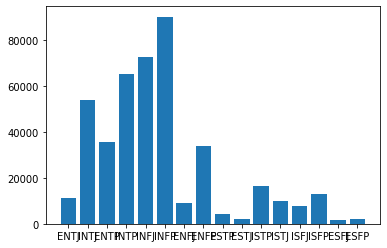

None


In [76]:
file1 = CsvToDf("../data/mbti_1.csv",batchSize=400)
combine = Combiner([file1],[["type","posts"]])
res = countOccurences(combine)
print(printHistogramUnique(getUniqueOcur(res)))

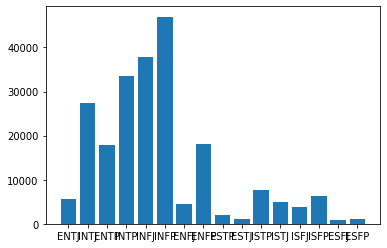

None


In [70]:
file1 = CsvToDf("../data/mbti_1.csv",batchSize=400,preProc=True,postCol="posts")
combine = Combiner([file1],[["type","posts"]])
res = countOccurences(combine)
print(printHistogramUnique(getUniqueOcur(res)))

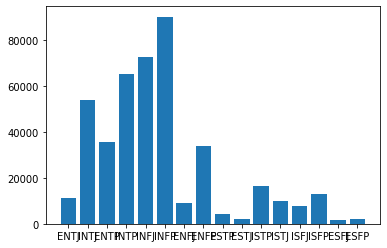

None


In [67]:
file1 = CsvToDf("../data/mbti_full_pull.csv",batchSize=400)
combine = Combiner([file1],[["subreddit","body"]])
res = countOccurences(combine)
print(printHistogramUnique(getUniqueOcur(res)))

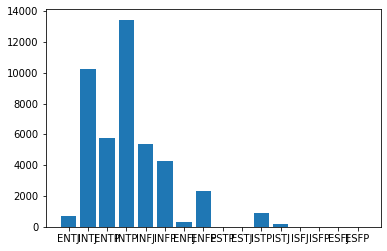

None


In [71]:
file1 = CsvToDf("../data/mbti_full_pull.csv",batchSize=400)
combine = Combiner([file1],[["subreddit","body"]])
res = countOccurences(combine)
print(printHistogramUnique(getUniqueOcur(res)))

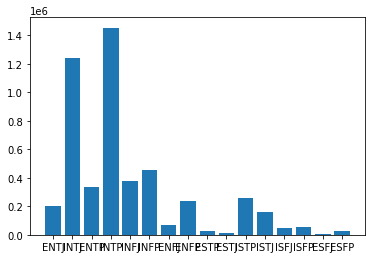

None


In [73]:
file1 = CsvToDf("../data/mbti9k_comments.csv",batchSize=400)
combine = Combiner([file1],[["type","comment"]])
res = countOccurences(combine)
print(printHistogramUnique(getUniqueOcur(res)))

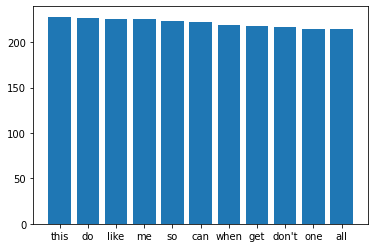

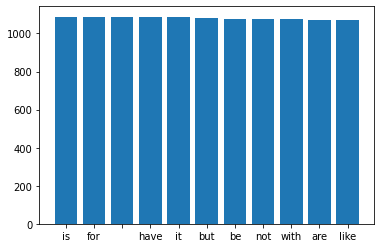

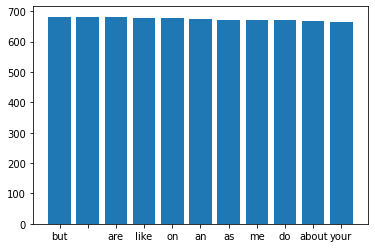

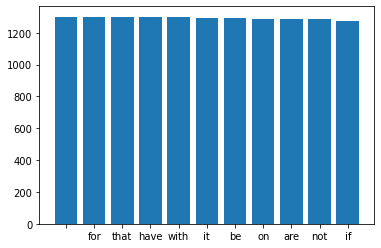

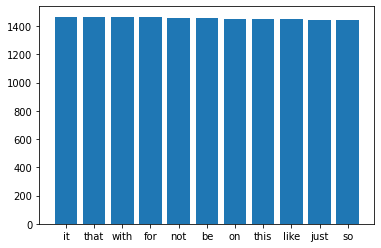

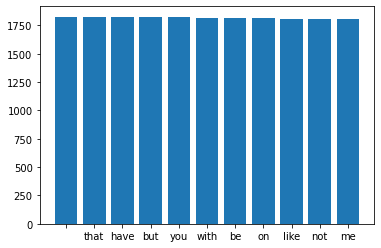

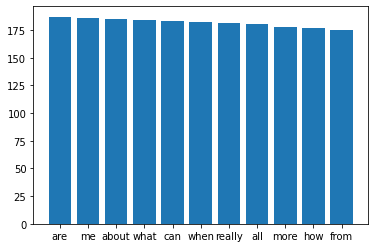

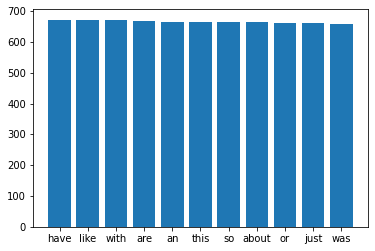

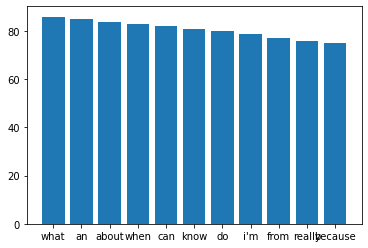

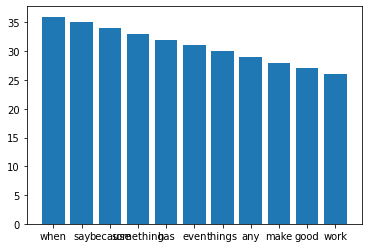

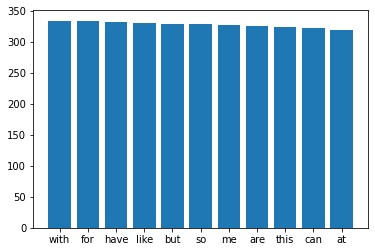

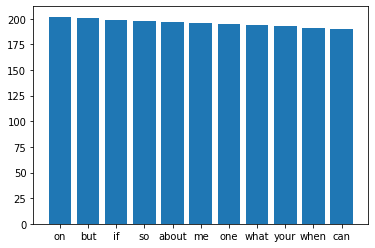

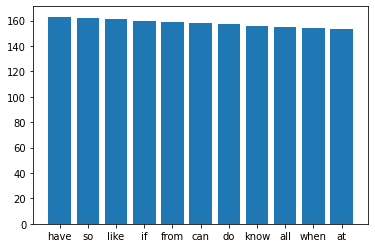

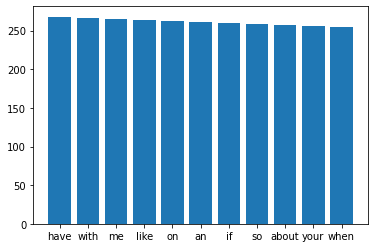

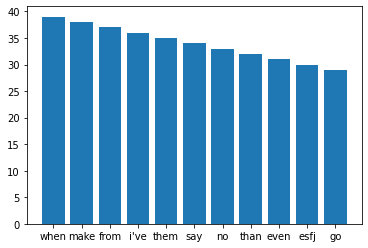

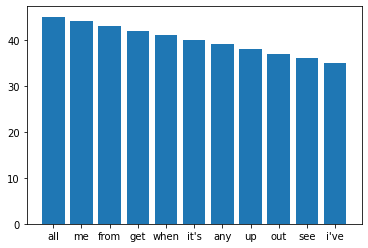

In [36]:
printHistogram(res)

In [46]:
def getUniqueWords(aDict):
    personality_dict = {"ENTJ" : [], "INTJ" : [], "ENTP" : [], "INTP" : [], "INFJ" : [], "INFP" : [], "ENFJ" : [], 
                    "ENFP" : [], "ESTP" : [], "ESTJ" : [], "ISTP" : [], "ISTJ" : [], "ISFJ" : [], "ISFP" : [], 
                    "ESFJ" : [], "ESFP" : []}
    for personality in aDict:
        for word in aDict[personality]:
            unique = True
            for personality2 in aDict:
                if personality == personality2:
                    continue
                if word in aDict[personality2]:
                    unique = False
                    continue
            if unique:
                personality_dict[personality].append(word)
    return personality_dict

In [73]:
file1 = CsvToDf("../data/mbti_1.csv",batchSize=400)
combine = Combiner([file1],[["type","posts"]])
res = getUniqueWords(countOccurences(combine))

In [74]:
print(res["ENTJ"])

['about?|||callaendia', 'https://www.youtube.com/watch?v=xh0va6_8mv8|||i', 'loyalty:', 'refute.', "ass.|||i'll", 'super-duper-long-ass', 'similar.|||3x|||11/25', 'later.|||the', 'bs...|||but', 'efficient/effective', "fired.|||that's", 'same.|||just', 'ha!|||the', 'fuuuuu|||those', 'jigsaw,', 'quickly.|||https://encrypted-tbn2.gstatic.com/images?q=tbn:and9gcsda-gnswrqdgxzibqpn3dfs2llchp8to6fccevbhuilyuvfjzkvh2sgav_', 'reenactment.|||and', 'op.|||hey', 'course,...|||your', 'taddling.', 'them.|||tl;dr', 'spotlight.|||i', 'vacation.|||two', 'dream...|||lol', 'interest.|||on', ':laughing:|||hitler', 'dogmas', 'uncorrupt.', 'it.|||dead', 'shit?|||i', 'http://youtu.be/paghidsjkvq|||mbtipc', 'wine:', 'liquor:', 'to...|||hitler', 'victim.|||sometimes', 'tenet,', 'effects,...|||you', 'nameuser', 'everything.|||never', 'ales.', 'stupidity/laziness.', 'deposition', 'employer...|||lol.', 'cran', "overboard...|||http://www.penciltribe.com/cms/wp-content/uploads/2013/04/brian_snowflake-300x225.jpg|||

In [75]:
file1 = CsvToDf("../data/mbti_1.csv",batchSize=400,preProc=True,postCol="posts")
combine = Combiner([file1],[["type","posts"]])
res = getUniqueWords(countOccurences(combine))

In [76]:
print(res["ENTJ"])

['reenactment.', 'loyalty:', 'refute.', 'super-duper-long-ass', 'efficient/effective', 'jigsaw,', 'taddling.', '@darth', 'dogmas', 'uncorrupt.', 'wine:', 'callaendia', 'liquor:', 'tenet,', 'nameuser', 'ales.', 'stupidity/laziness.', 'deposition', 'effects,...', 'cran', 'marx?', 'unsolicited.', 'reeeeeeaaallly', 'mulcher.', '11/25', 'tarp,', 'ciders', 'sieg', 'waylaid.', 'ither', 'voxel', 'azeri', 'alkhemia', 'toolbars', 'machi?', 'toolbars.', 'kazakhstan!', 'azerbaijan', 'unturned?', 'welcome!...', 'crashing.', 'circumstanses,', 'fart...', 'congraz', '(oddly).', 'boooooooooiiiiiii', 'reddington', 'death/betrayal', 'heil-ing', 'm80', 'lionfart!', ':crazy:p', 'd:crazy:', 'yxz', 'y:crazy:', 'experiments!', 'unclear?', 'cheesecloth.', 'weight),', 'tuesday:', "accomplishment.'", 'half-caf...', '(mandatory', 'format/style', 'wednesday:', 'aggresiveness', 'format/presentation', 'interviewee...', 'slowing.', 'ignored?', 'breasts...', '58551', '@doll', 'benja...', 'attend).', 'me...oh,', 'grade

In [84]:
def getCommonWords(aDict):
    outWords = []
    for personality in aDict:
        for word in aDict[personality]:
            common = True
            for personality2 in aDict:
                if personality == personality2:
                    continue
                if word not in aDict[personality2]:
                    common = False
                    break
            if common:
                outWords.append(word)
    return outWords

In [85]:
file1 = CsvToDf("../data/mbti_1.csv",batchSize=400,preProc=True,postCol="posts")
combine = Combiner([file1],[["type","posts"]])
res = getCommonWords(countOccurences(combine))

In [86]:
print(res)

['', 'sweet', 'deal', 'month', 'then', 'know', 'thought', 'up.', 'off', 'asking', 'he', 'idea.', 'crush', 'this', 'college', 'it', 'most', 'dealing', 'late', 'key', 'his', 'talk', 'oh', 'those', 'everything.', 'taken', 'our', 'instead', 'me', 'like', 'later.', 'terms', 'no', 'answer', '6', 'over', 'do', 'from', 'maybe', 'to...', 'something', 'woman', 'some', 'would', 'using', 'got', 'not', 'negative', 'is...', 'guys.', 'infp', 'other', 'interested.', 'five', 'doing', 'use', 'too.', 'objective', 'better', 'him.', 'fuck', 'it.', 'now', 'focus', 'to', 'him,', 'at', 'approach', 'wrong', 'are', 'everything', 'higher', 'them.', 'but', 'because', 'met', 'anything.', 'yes.', 'others,', 'entjs', 'in', 'wanted', 'middle', 'drink', 'guys', 'anything', 'well', 'your', 'is', 'lol.', 'does', 'waste', 'am', 'comments', 'every', 'parents', 'we', 'lives', 'my', 'entj', 'into', 'but...', 'too', 'testing', 'cry', 'being', 'good', 'lol', 'poor', 'you', 'people', 'way', 'never', 'mind.', 'share', 'sometime

In [109]:
file1 = CsvToDf("../data/mbti_1.csv",batchSize=400,preProc=True,postCol="posts",toReplace=["month","then","deal","sweet"])
combine = Combiner([file1],[["type","posts"]])
res = getCommonWords(countOccurences(combine))

In [110]:
print(res)

['know', 'thought', 'up.', 'off', 'asking', 'he', 'idea.', 'crush', 'this', 'college', 'it', 'most', 'dealing', 'late', 'key', 'his', 'talk', 'oh', 'those', 'everything.', 'taken', 'our', 'instead', 'me', 'like', 'later.', 'terms', 'no', 'answer', '6', 'over', 'do', 'from', 'maybe', 'to...', 'something', 'woman', 'some', 'would', 'using', 'got', 'not', 'negative', 'is...', 'guys.', 'infp', 'other', 'interested.', 'five', 'doing', 'use', 'too.', 'objective', 'better', 'him.', 'fuck', 'it.', 'now', 'focus', 'to', 'him,', 'at', 'approach', 'wrong', 'are', 'everything', 'higher', 'them.', 'but', 'because', 'met', 'anything.', 'yes.', 'others,', 'entjs', 'in', 'wanted', 'middle', 'drink', 'guys', 'anything', 'well', 'your', 'is', 'lol.', 'does', 'waste', 'am', 'comments', 'every', 'parents', 'we', 'lives', 'my', 'entj', 'into', 'but...', 'too', 'testing', 'cry', 'being', 'good', 'lol', 'poor', 'you', 'people', 'way', 'never', 'mind.', 'share', 'sometimes', 'harder', 'to.', 'others', 'situat